# Analisi esplorativa e clustering

Questo notebook presenta l'analisi esplorativa del training set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import seaborn as sns

import tqdm

from sklearn.decomposition import PCA
from sklearn import preprocessing

# %matplotlib inline

# tune this for bigger figures
pl.rcParams['figure.figsize'] = (14, 14)
sns.set_context('notebook')

Carichiamo il dataset:

In [2]:
dataset_raw = pd.read_excel("./Dataset/finali/integrato_2014.xlsx", sheet_name='ML_finale')
dataset_raw.head()

,Country code,Country name,Population,CO2 production (kg),Charcoal consumption (kg),Fuel oil consumption (kg),Renewable energy consumption (percentage),PM2.5 (micrograms),GDP
0,AFG,Afghanistan,32758020,9.809225e+09,1.259260e+08,4.407000e+08,16.748996,49.026761,2.005019e+10
1,AGO,Angola,26920466,3.476316e+10,1.164000e+09,3.081000e+03,50.797466,35.129513,1.267770e+11
2,AND,Andorra,79223,4.620420e+08,2.900000e+04,1.299600e+02,19.886327,10.389338,3.350736e+09
3,ARE,United Arab Emirates,9070867,2.113695e+11,6.400000e+07,4.957000e+03,0.167807,67.175459,4.031980e+11
4,ARG,Argentina,42981515,2.040245e+11,4.940000e+08,9.759000e+03,10.773125,13.678616,5.263200e+11


Normalizziamo gli attributi rispetto alla popolazione:

In [3]:
def normalize_with_col(dataset, norm_col_name, cols_to_normalize):
    """Divide all columns in a dataset for the normalization column."""
    norm_col = dataset[norm_col_name]
    result = dataset.copy()
    
    for col in cols_to_normalize:
        result[col] = result[col] / norm_col
    
    return result

In [4]:
dataset = normalize_with_col(dataset_raw, 'Population', ['CO2 production (kg)',
                                                       'Charcoal consumption (kg)',
                                                       'Fuel oil consumption (kg)',
                                                       'GDP',
                                                       'PM2.5 (micrograms)'])
# Peek at the data
dataset.head()

,Country code,Country name,Population,CO2 production (kg),Charcoal consumption (kg),Fuel oil consumption (kg),Renewable energy consumption (percentage),PM2.5 (micrograms),GDP
0,AFG,Afghanistan,32758020,299.444991,3.844127,13.453194,16.748996,1.496634e-06,612.069651
1,AGO,Angola,26920466,1291.328315,43.238479,0.000114,50.797466,1.304937e-06,4709.316696
2,AND,Andorra,79223,5832.169951,0.366055,0.001640,19.886327,1.311404e-04,42294.994724
3,ARE,United Arab Emirates,9070867,23302.022508,7.055555,0.000546,0.167807,7.405627e-06,44449.775308
4,ARG,Argentina,42981515,4746.797455,11.493313,0.000227,10.773125,3.182442e-07,12245.264040


## Statistiche descrittive per il dataset

Il dataset contiene 153 istanze di paesi, ognuna con gli attributi

- popolazione
- produzione di CO_2 annuale (in kg)
- consumo di carbone annuale (in kg)
- consumo di carburanti fossili annuale (in kg)
- percentuale di energia rinnovabile utilizzata, rispetto all'utilizzo totale di quel paese
- GDP (prodotto interno lordo)

Vediamo come sono distribuite le variabili.

In [5]:
dataset.describe()

,Population,CO2 production (kg),Charcoal consumption (kg),Fuel oil consumption (kg),Renewable energy consumption (percentage),PM2.5 (micrograms),GDP
count,1.530000e+02,153.000000,153.000000,1.530000e+02,153.000000,1.530000e+02,153.000000
mean,4.388212e+07,4190.103188,17.168798,8.814228e-02,35.687487,1.381002e-05,11756.843728
std,1.560372e+08,6372.361344,25.588456,1.087609e+00,29.876964,2.880287e-05,16910.303310
min,7.277800e+04,44.485376,0.008927,5.180149e-07,0.000000,2.667771e-08,312.748979
25%,2.374419e+06,564.368357,1.077500,4.436075e-05,9.798903,1.080449e-06,1569.928275
50%,9.474511e+06,1902.758910,3.325575,1.342412e-04,28.721289,2.937157e-06,4712.822736
75%,2.832324e+07,5260.352041,29.347377,2.915885e-04,59.903202,1.068541e-05,14201.434596
max,1.364270e+09,45423.239959,138.779013,1.345319e+01,93.859219,1.884716e-04,97200.009655


Ora vediamo la distribuzione delle features:

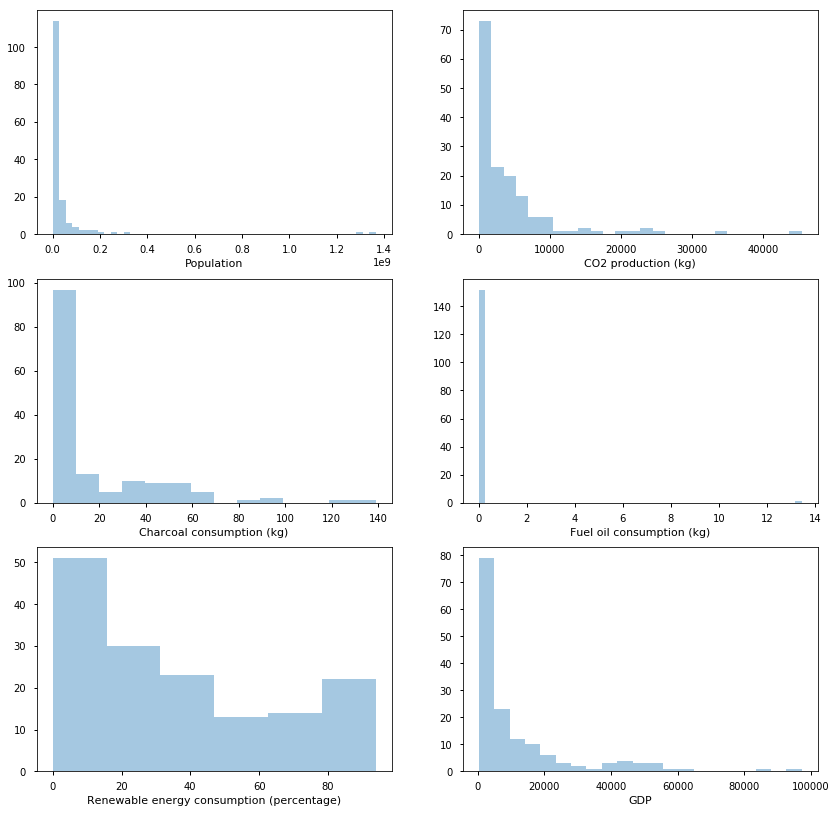

In [6]:
# Plot the population-scaled dataset
fig, ax = pl.subplots(3, 2, figsize=(14, 14))

plot_kde = False

sns.distplot(dataset['Population'], ax=ax[0, 0], kde=plot_kde)
sns.distplot(dataset['CO2 production (kg)'], ax=ax[0, 1], kde=plot_kde)
sns.distplot(dataset['Charcoal consumption (kg)'], ax=ax[1, 0], kde=plot_kde)
sns.distplot(dataset['Fuel oil consumption (kg)'], ax=ax[1, 1], kde=plot_kde)
sns.distplot(dataset['Renewable energy consumption (percentage)'], ax=ax[2, 0], kde=plot_kde)
sns.distplot(dataset['GDP'], ax=ax[2, 1], kde=plot_kde)
pl.show()

In [7]:
def standardize(dataset, cols):
    """Standardize dataset."""
    result = dataset.copy()
    for col in cols:
        vals = preprocessing.scale(dataset[col].values)
        result.loc[:, col] = vals

    return result

In [8]:
dataset_std = standardize(dataset,
                           ['Population',
                            'CO2 production (kg)',
                            'Charcoal consumption (kg)',
                            'Fuel oil consumption (kg)',
                            'Renewable energy consumption (percentage)',
                            'GDP'])

/Users/pietro/Documents/Universita/Progetto_DT_ML/.venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


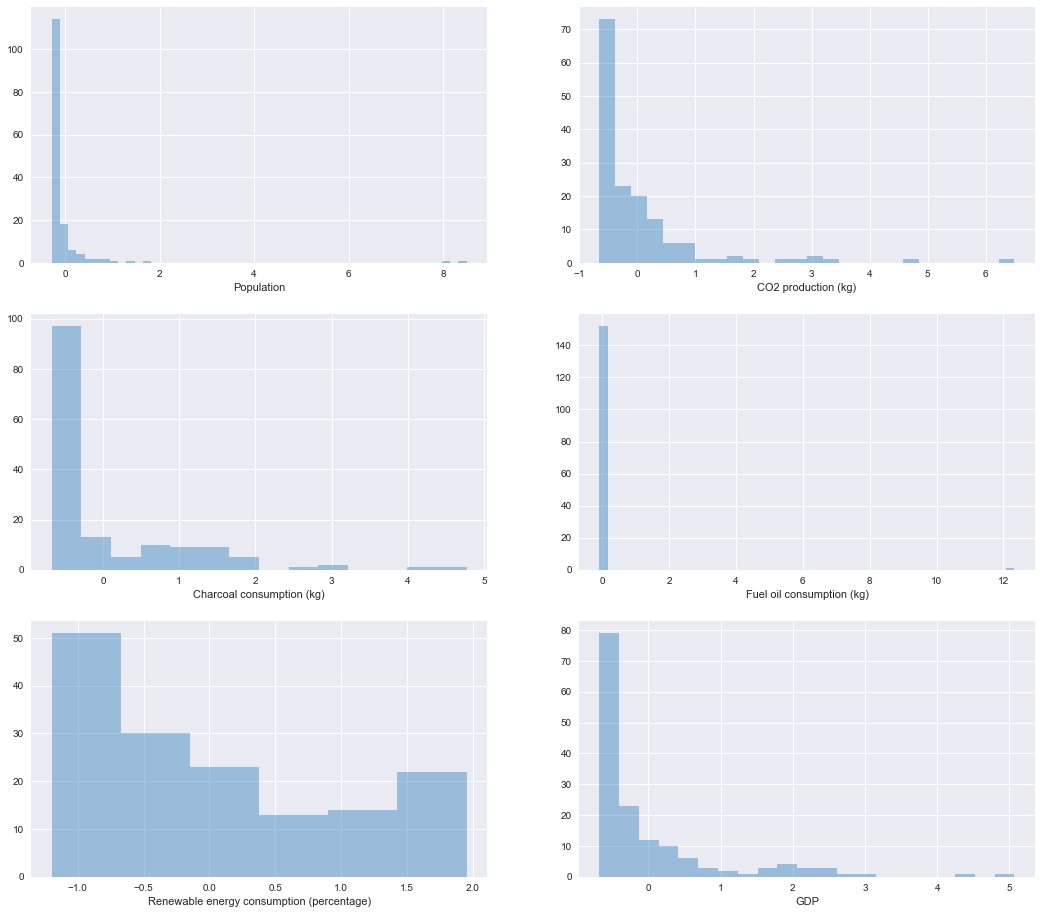

In [9]:
# Plot the standardized population-scaled dataset
with sns.axes_style("darkgrid"):
    fig, ax = pl.subplots(3, 2, figsize=(18, 16))

    sns.distplot(dataset_std['Population'], ax=ax[0, 0], kde=False)
    sns.distplot(dataset_std['CO2 production (kg)'], ax=ax[0, 1], kde=False)
    sns.distplot(dataset_std['Charcoal consumption (kg)'], ax=ax[1, 0], kde=False)
    sns.distplot(dataset_std['Fuel oil consumption (kg)'], ax=ax[1, 1], kde=False)
    sns.distplot(dataset_std['Renewable energy consumption (percentage)'], ax=ax[2, 0], kde=False)
    sns.distplot(dataset_std['GDP'], ax=ax[2, 1], kde=False)

    pl.show()

## Correlazione tra features

Esploriamo la correlazione tra le features con una heatmap:

In [10]:
def create_heatmap(dataset, figsize=(14, 14)):
    """Create a heatmap from the dataset."""
    # Compute the correlation matrix
    corr = dataset.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = pl.subplots(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.color_palette("RdBu")
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, cmap=cmap, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

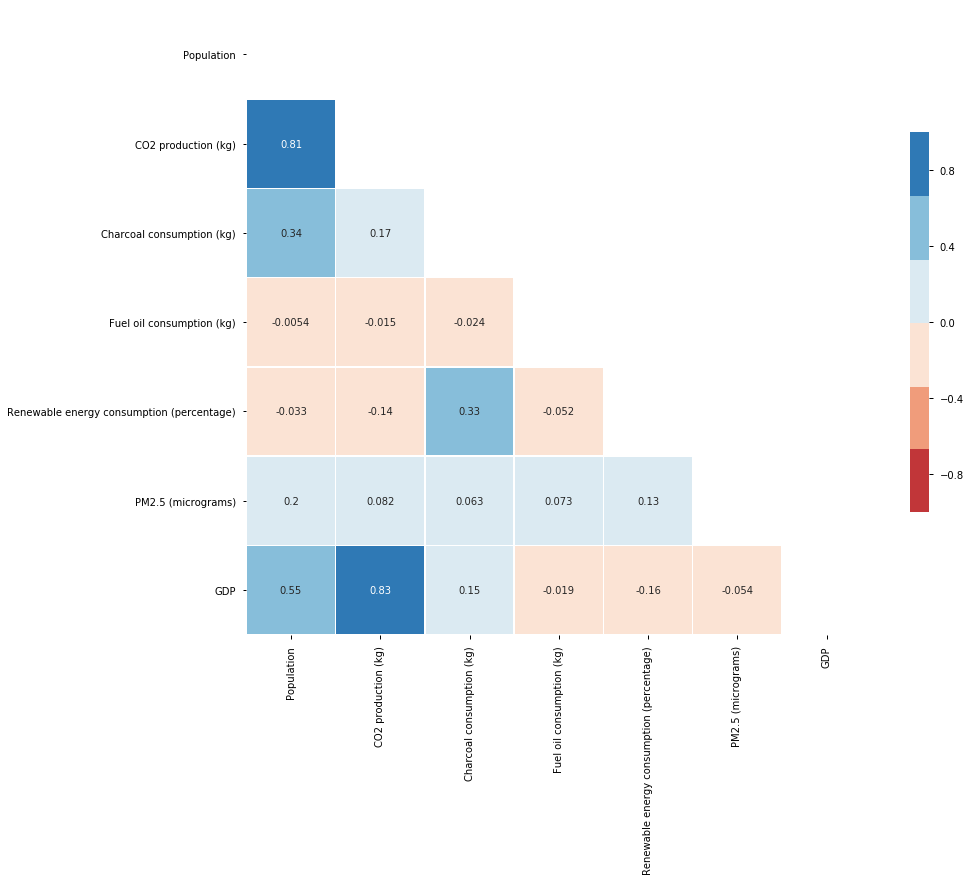

In [11]:
create_heatmap(dataset_raw)

## Analisi PCA per la varianza spiegata

Vediamo il contributo di ogni feature alla varianza spiegata dei dati:

In [12]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(dataset_std.loc[:,['CO2 production (kg)',
                                             'Charcoal consumption (kg)',
                                             'Renewable energy consumption (percentage)',
                                             'GDP']])
pca.explained_variance_ratio_

array([0.6041384 , 0.2215172 , 0.10623035, 0.06811406])

In [13]:
def plot_explained_variance(pca_obj, threshold=0.9):
    n = len(pca_obj.explained_variance_ratio_)
    x_vals = np.arange(n)
    
    # bar chart
    pl.bar(x_vals,
           pca_obj.explained_variance_ratio_,
           alpha=0.5,
           align="center",
           label="Single feature explained variance")
    
    # step plot
    pl.step(x_vals,
            np.cumsum(pca_obj.explained_variance_ratio_),
            where="mid",
            label="Cumulative explained variance")
    
    # threshold
    pl.plot(x_vals,
           threshold * np.ones(x_vals.shape),
           linestyle='--',
           label="{}% threshold".format(threshold * 100))
    
    pl.xlabel("Principal components")
    pl.ylabel("Explained variance ratio")
    pl.legend(loc="center right")
    pl.show()

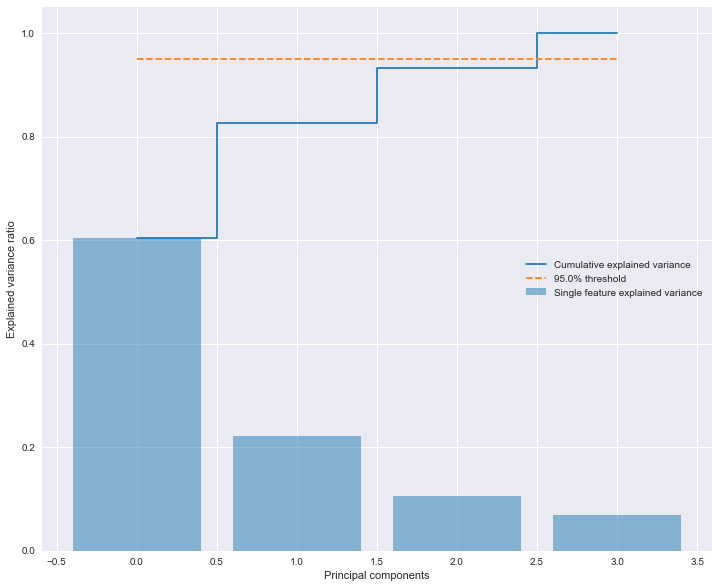

In [14]:
with sns.axes_style('darkgrid'):
    fig, ax = pl.subplots(ncols=1, figsize=(12, 10))
    plot_explained_variance(pca, threshold=0.95)

# K-Means con Scikit-Learn

Ora che abbiamo esplotato il dataset, utilizziamo Sklearn per indurre un modello K-Means.

Per prima cosa, importiamo la libreria:

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Selezione delle feature

Da quanto emerge dall'analisi esplorativa, la feature "Fuel Oil Consumption" è estremamente sbilanciata verso lo zero, con solo l'Afghanistan a superare quota 10 kg per-capita.

In base a ciò, si è deciso di eliminare la feature e ritenere soltanto le altre, scalate rispetto alla popolazione e standardizzate.

In [16]:
data_km = dataset.copy()
data_km = data_km.drop(columns=['Fuel oil consumption (kg)', 'Population'])
data_km = data_km.rename(columns={'CO2 production (kg)':'CO2',
                           'Charcoal consumption (kg)': 'Charcoal',
                           'Renewable energy consumption (percentage)': 'Clean energy',
                           'PM2.5 (micrograms)': 'PM2.5'})
data_km.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,299.444991,3.844127,16.748996,1.496634e-06,612.069651
1,AGO,Angola,1291.328315,43.238479,50.797466,1.304937e-06,4709.316696
2,AND,Andorra,5832.169951,0.366055,19.886327,1.311404e-04,42294.994724
3,ARE,United Arab Emirates,23302.022508,7.055555,0.167807,7.405627e-06,44449.775308
4,ARG,Argentina,4746.797455,11.493313,10.773125,3.182442e-07,12245.264040


### Pair-wise plot delle feature scelte


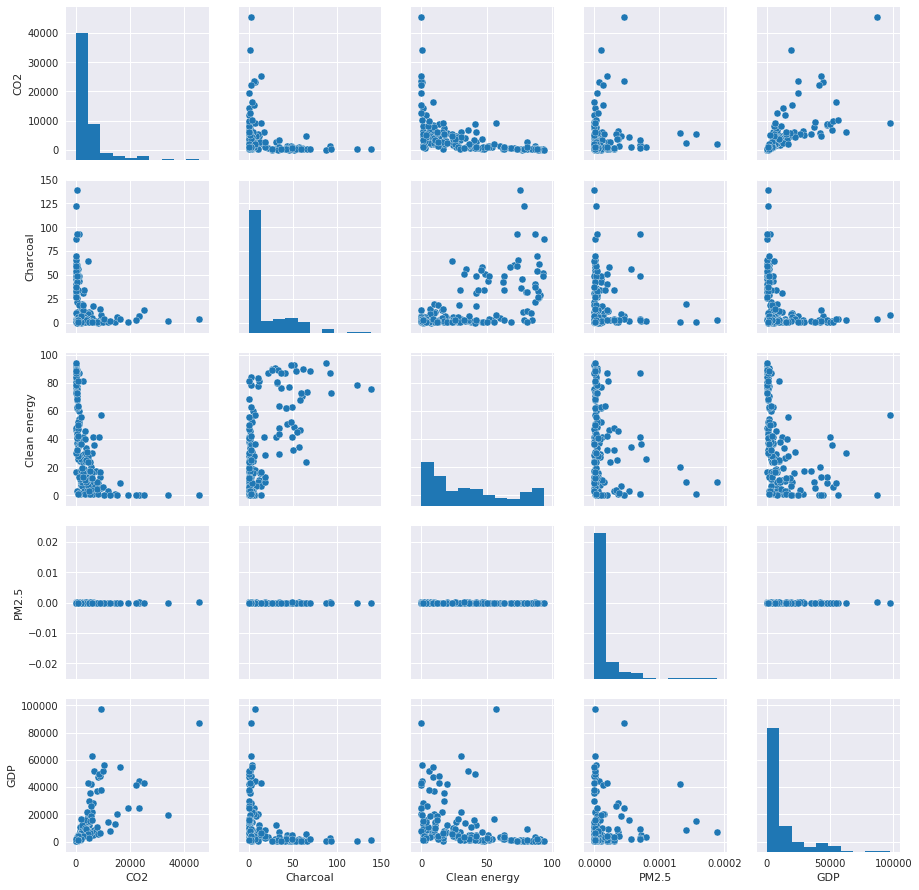

In [17]:
with sns.axes_style('darkgrid'):
    sns.pairplot(data_km)
pl.show()

Ora normalizziamo il dataset per il K-Means:

In [18]:
data_km = standardize(data_km, ['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP'])
data_km.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,-0.612557,-0.522440,-0.635964,-0.428910,-0.661217
1,AGO,Angola,-0.456392,1.022152,0.507401,-0.435587,-0.418128
2,AND,Andorra,0.258532,-0.658810,-0.530611,4.086945,1.811821
3,ARE,United Arab Emirates,3.009039,-0.396525,-1.192769,-0.223083,1.939663
4,ARG,Argentina,0.087648,-0.222527,-0.836637,-0.469956,0.028978


## Clustering

Ora che il dataset è standardizzato, procediamo a clusterizzare.

Per trovare la migliore clusterizzazoine, creiamo una funzione.

In [19]:
def clusterize(X, min_clusters, max_clusters):
    n_clusters = list(range(min_clusters, max_clusters + 1))
    
    # (i, j) -> label for data point i when using n_clusters[j] clusters
    labels = np.zeros((X.shape[0], len(n_clusters)), dtype=np.int16)
    
    # (0, j) -> average silhouette score when using n_clusters[j] clusters
    silh_tot = np.zeros((1, len(n_clusters)))
    
    # (i, j) -> silhouette score for data point i when using n_clusters[j] clusters
    silh_ith = np.zeros((X.shape[0], len(n_clusters)))
    
    for ind, n in enumerate(tqdm.tqdm_notebook(n_clusters)):
#        print("Iterating with {}/{} clusters".format(n, n_clusters[-1]))
        clusterer = KMeans(n_clusters=n, init='k-means++', n_init=30,
                           max_iter=10000, tol=1e-5,
                           precompute_distances=True, random_state=10,
                           n_jobs=1)
        
        curr_labels = clusterer.fit_predict(X)
        labels[:, ind] = curr_labels

        silhouette_avg = silhouette_score(X, curr_labels)
        silh_tot[0, ind] = silhouette_avg

        curr_silhouette_values = silhouette_samples(X, curr_labels)
        silh_ith[:, ind] = curr_silhouette_values

    ret_labels = pd.DataFrame(data=labels, columns=n_clusters)
    ret_silh_avg = pd.DataFrame(data=silh_tot, columns=n_clusters)
    ret_silh_point = pd.DataFrame(data=silh_ith, columns=n_clusters)

    return ret_labels, ret_silh_avg, ret_silh_point

Ora lanciamo il K-Means su un numero variabile di clusters, da 2 a 100. Vediamo poi quale è il migliore con l'indice di silhouette

In [20]:
data_values = data_km[['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP']].values
labels, avg_silhouette, point_silhouette = clusterize(data_values, 2, 100)

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

In [21]:
best_index = np.argmax(avg_silhouette.values)
best_silhouette = avg_silhouette.iloc[0, best_index]
best_n_cluster = avg_silhouette.columns[best_index]
print("Best silhouette score is {:6.4f} with {} clusters"
     .format(best_silhouette, best_n_cluster))

Best silhouette score is 0.4302 with 5 clusters


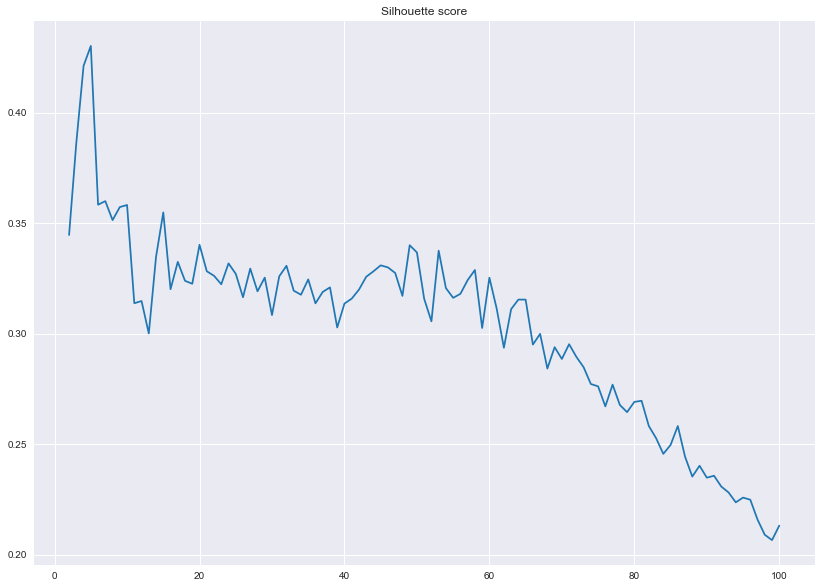

In [22]:
### Plot andamento silhouette media con il numero di clusters
with sns.axes_style('darkgrid'):    
    avg_silh_plot = avg_silhouette.loc[0, :].values
    fig, ax = pl.subplots(ncols=1, figsize=(14, 10))
    pl.plot(np.array(avg_silhouette.columns.tolist()), avg_silh_plot)
    ax.set_title("Silhouette score")
    
    pl.show()

### Plot dei valori di silhouette

Definiamo una funzione per plottare la silhouette:

In [23]:
def plot_silhouette(cluster_labels, avg_silh, point_silh, n_clusters, fig, ax):
    """Make a silhouette plot.
    
    Parameters
    ----------
    data: pd.DataFrame
        data corresponding to the plots
        
    cluster_labels: np.array of shape (n_points, 1)
        labels of the cluster for each data point
    
    point_silh: np.array (n_points, 1)
        silhouette for each data point at the defined cluster number n_clusters
    
    avg_silh: float
        average silhouette score for this clusterization
    """
    min_silh_score = point_silh.min()
    max_silh_score = point_silh.max()
    
    ax.set_xlim([min_silh_score, max_silh_score])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])
    
    y_lower = 10
    
    for i in range(n_clusters):
        # aggregate silhouette by cluster label and sort it
        silh_values_cluster_i = point_silh[cluster_labels == i]
        silh_values_cluster_i.sort()
        
        ith_cluster_size = silh_values_cluster_i.shape[0]
        y_upper = y_lower + ith_cluster_size
        
        color = cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, silh_values_cluster_i,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label with the cluster number in the middle
        ax.text(-0.06, y_lower + 0.5 * ith_cluster_size, "Cluster {}".format(str(i)))
        y_lower = y_upper + 10
    
    ax.set_title("Silhouette plot con {} clusters".format(n_clusters))
#    ax.set_yticks([])
    ax.axvline(x=avg_silh, color='blue', linestyle='--')
    
    return fig, ax

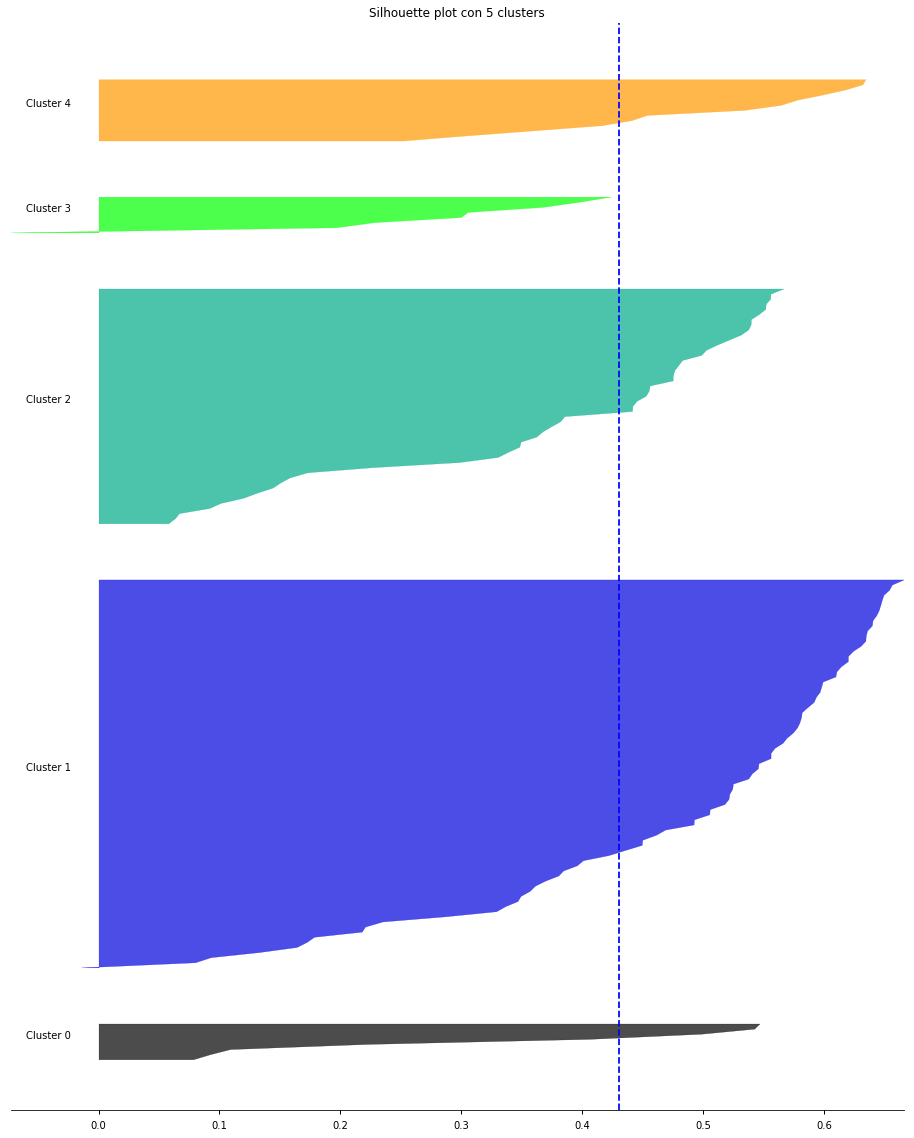

In [24]:
fig, ax = pl.subplots(ncols=1, figsize=(16, 20))
plot_silhouette(labels[best_n_cluster].values,
                avg_silhouette[best_n_cluster].values,
                point_silhouette[best_n_cluster].values,
                best_n_cluster,
                fig, ax)
sns.despine()
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
pl.show()